<a href="https://colab.research.google.com/github/MRMVithun/MachineLearningDiabetes/blob/main/DiabetisPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import  XGBClassifier
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,roc_curve
from sklearn.model_selection import RandomizedSearchCV 
import warnings
from sklearn.externals import  joblib
warnings.simplefilter("ignore")


 



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data=pd.read_csv('/content/drive/MyDrive/diabetis/datasets_228_482_diabetes.csv')
Y=pd.DataFrame(data['Outcome'])
X=data.drop(['Outcome'],axis=1)

#Exploratory Data Analysis

In [ ]:
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


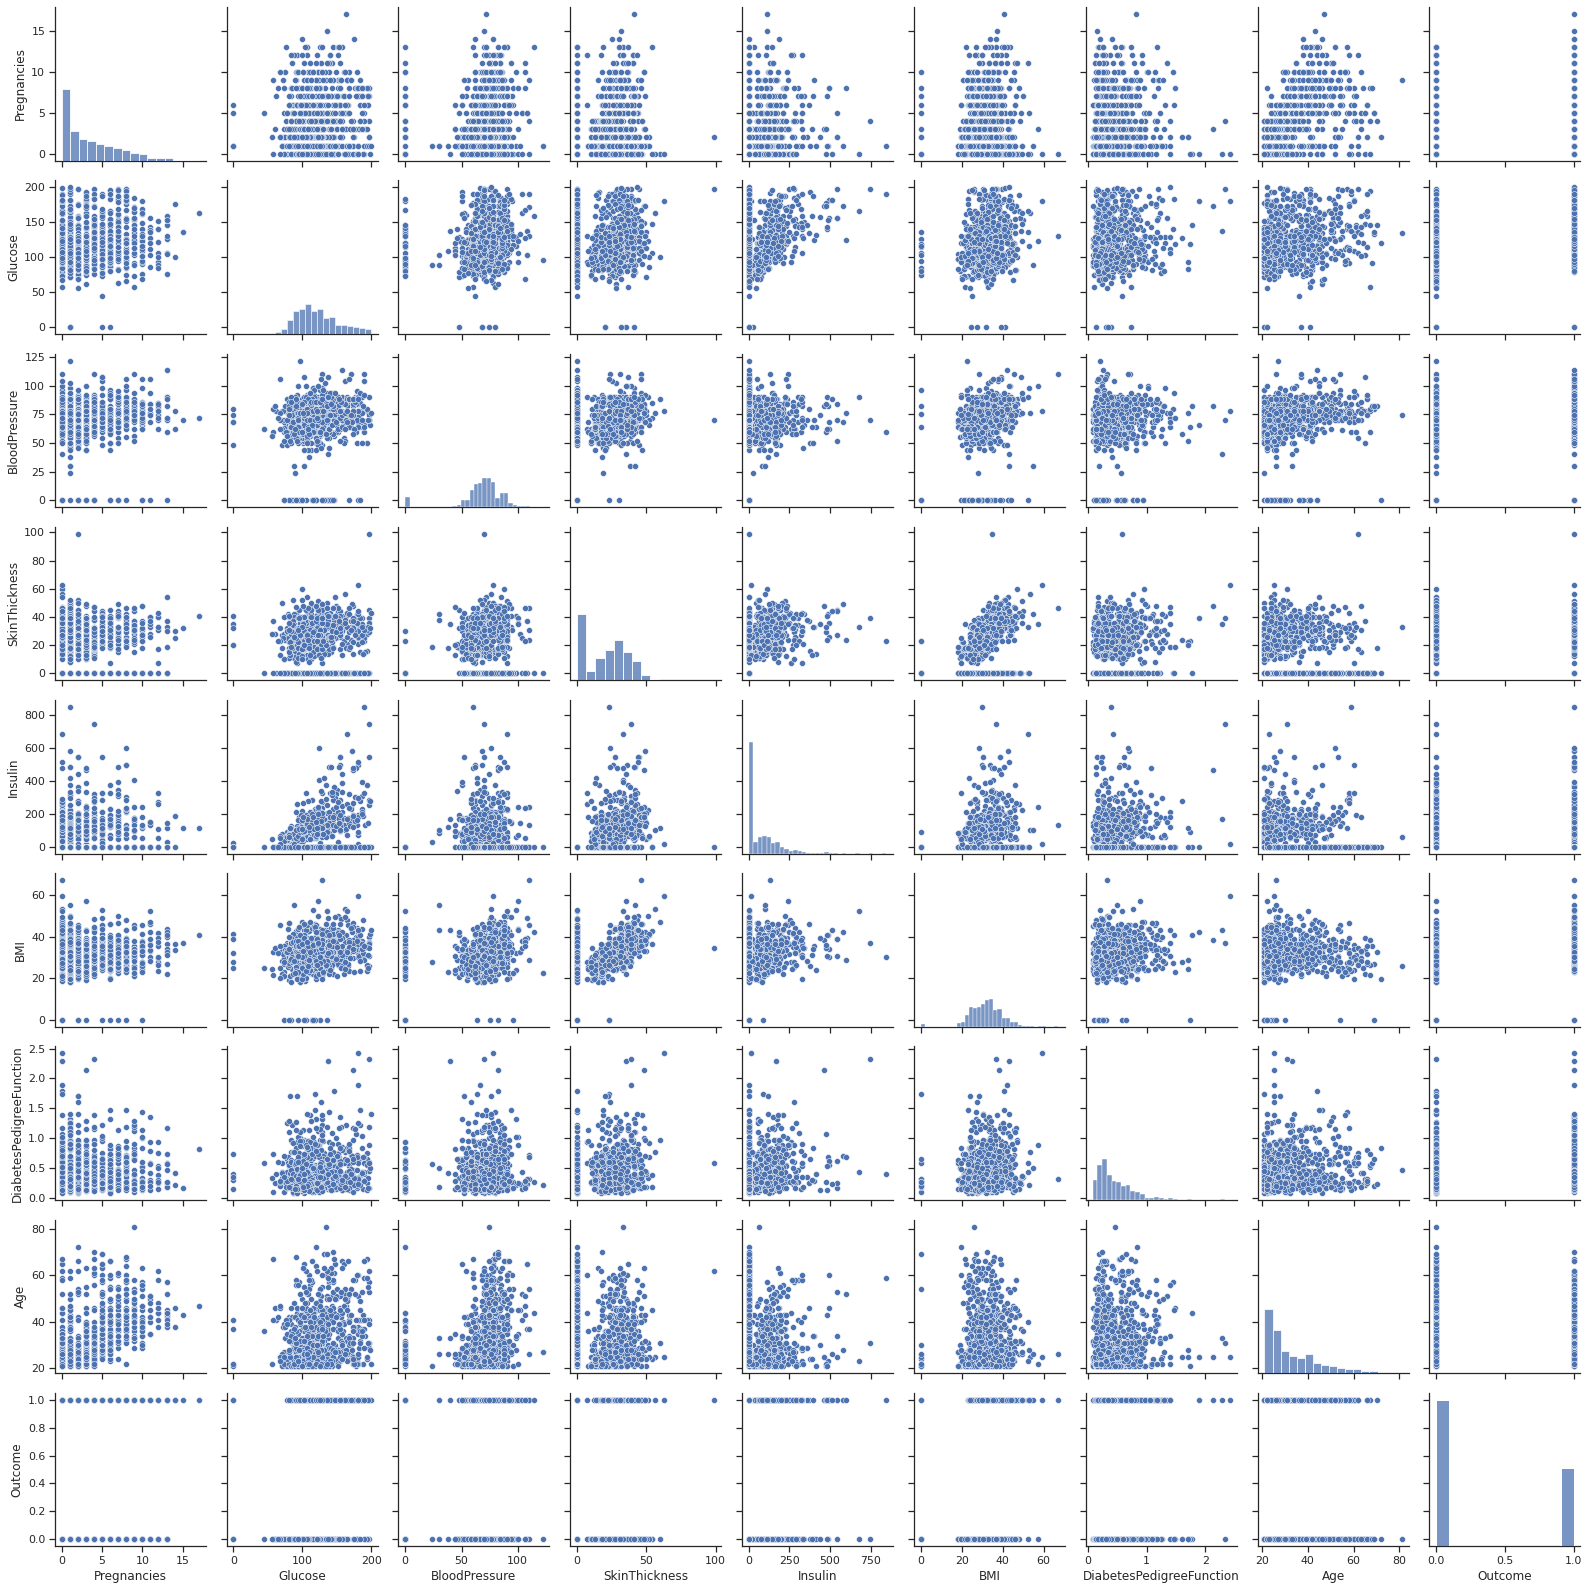

In [ ]:
sns.set(style="ticks", color_codes=True)
 
g = sns.pairplot(data)
plt.show()

Above distplot does not give much information so we going further 

                          Pregnancies   Glucose  ...       Age   Outcome
Pregnancies                  1.000000  0.129459  ...  0.544341  0.221898
Glucose                      0.129459  1.000000  ...  0.263514  0.466581
BloodPressure                0.141282  0.152590  ...  0.239528  0.065068
SkinThickness               -0.081672  0.057328  ... -0.113970  0.074752
Insulin                     -0.073535  0.331357  ... -0.042163  0.130548
BMI                          0.017683  0.221071  ...  0.036242  0.292695
DiabetesPedigreeFunction    -0.033523  0.137337  ...  0.033561  0.173844
Age                          0.544341  0.263514  ...  1.000000  0.238356
Outcome                      0.221898  0.466581  ...  0.238356  1.000000

[9 rows x 9 columns]


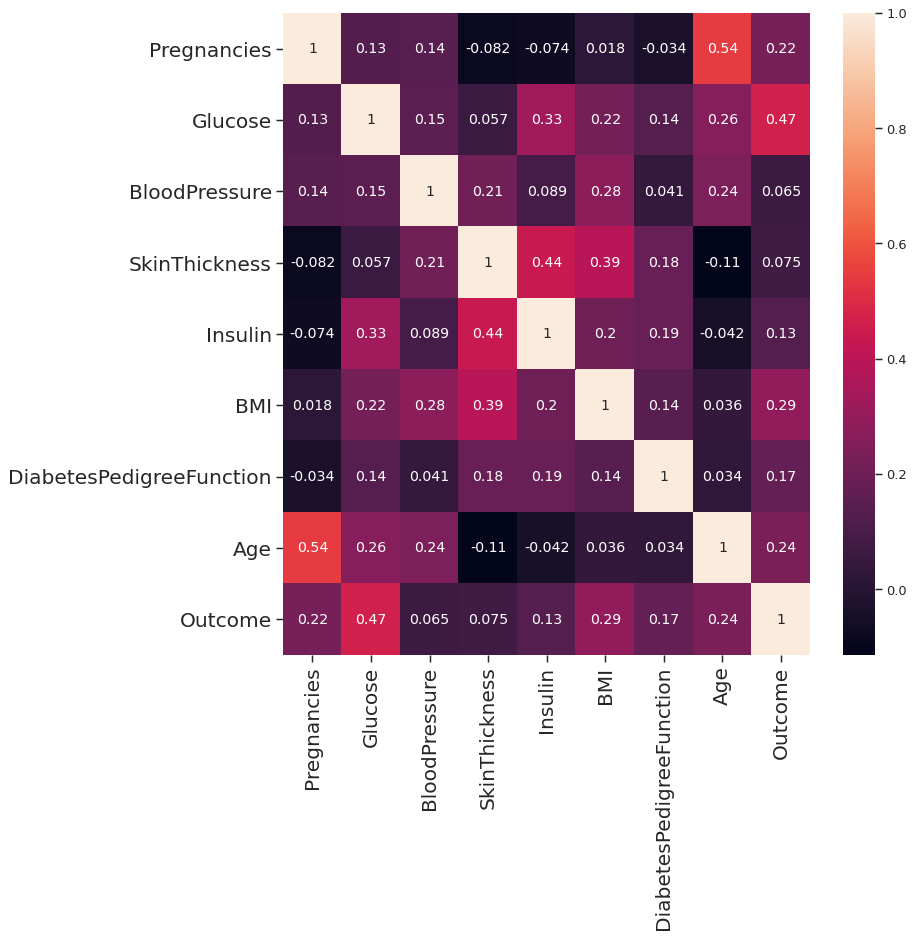

In [ ]:
corr = data.corr()
print(corr)
plt.figure(figsize=(10,10),dpi=85)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
sns.heatmap(corr, 
         xticklabels=corr.columns, 
         yticklabels=corr.columns,annot=True)

The above mentioned Co-relations shows that, featutes like Gulcome, Age, BMI, #Pregnencies have high corelation with the  outcome variable
Lighter and Brighter the color, Higher the Corelation, Higher Importance 

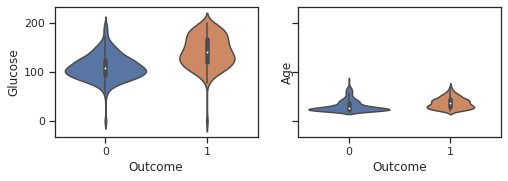

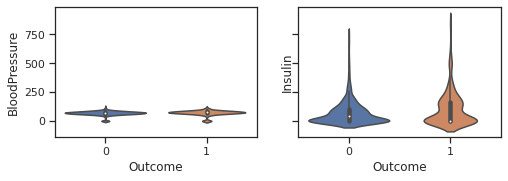

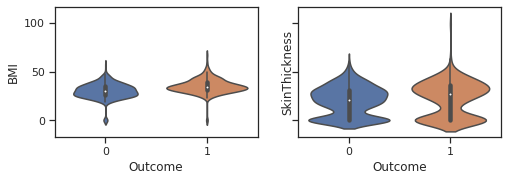

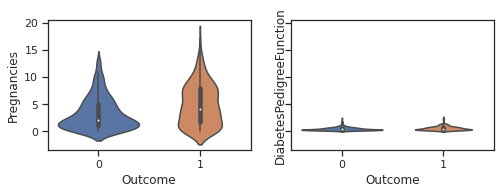

In [ ]:
columns = ['Glucose', 'Age', 'BloodPressure', 'Insulin','BMI','SkinThickness' ,'Pregnancies',  'DiabetesPedigreeFunction']
n_cols = 2
n_rows = 4
idx = 0

for i in range(n_rows):
    fg,ax = plt.subplots(nrows=1,ncols=n_cols,sharey=True,figsize=(8, 2.4))
    for j in range(n_cols):
        sns.violinplot(x = data.Outcome, y=data[columns[idx]], ax=ax[j]) 
        idx += 1
        if idx >= 8:
            break

Violin Plot clearly shows that all of the features are important features for classification 

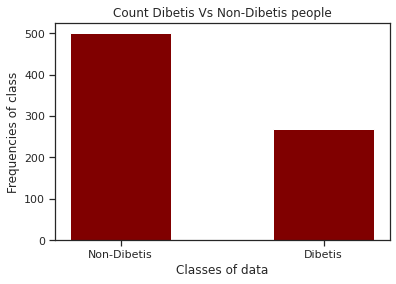

0    500
1    268
Name: Outcome, dtype: int64


In [ ]:
a=data.Outcome.value_counts()
stored={'Non-Dibetis':a[0],'Dibetis':a[1]}
xaxis=list(stored.keys())
yaxis=list(stored.values())
plt.bar(xaxis,yaxis, color='maroon',width=0.5)
plt.xlabel("Classes of data")
plt.ylabel("Frequencies of class")
plt.title("Count Dibetis Vs Non-Dibetis people")
plt.show()
print(data.Outcome.value_counts())

Above Bar Graph clearly shows that the data has more non-dibetic people than dibetic people. 500:268 is the ratio

In [ ]:
print("Is there any Null Values:",data.info())
# since non of the data are null we good to go

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
Is there any Null Values: None


# Data Preprocessing

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f454f0bf750>,
      dtype=object)

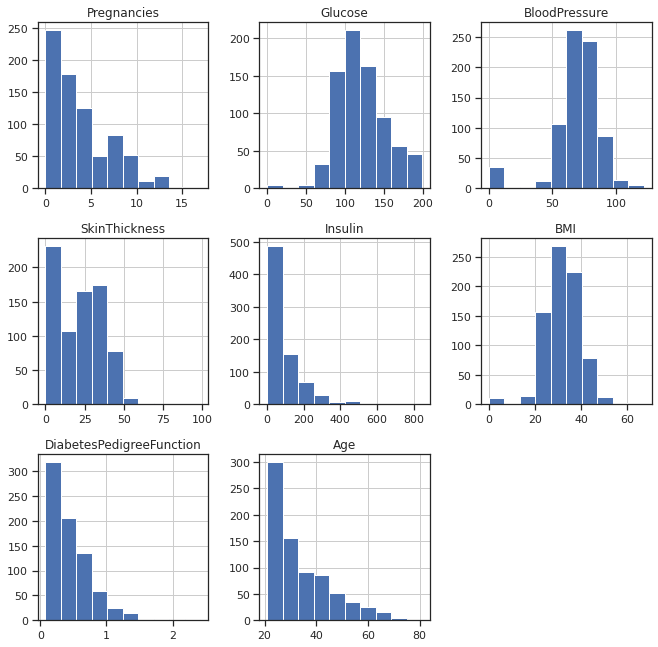

In [ ]:
X.hist(figsize=(11,11))

From the above figure, We found some value 0 which is unlikely to happen in real world situation. For example, Blood pressure can not be zero for a living person, we change it by median blood pressure value as follows. 

In [ ]:
X.loc[X['Glucose']==0,'Glucose']= X['Glucose'].median()
X.loc[X['BloodPressure']==0,'BloodPressure']=X['BloodPressure'].median()
X.SkinThickness.replace(0,X.SkinThickness.median(),inplace=True)
X.Insulin.replace(0,X.Insulin.median(), inplace=True)
X.BMI.replace(0,X.BMI.median(),inplace=True)

# Modeling 

First we apply  bunch of default models and see test accuracy for each default models, and based upon that we choose that model and proceed forward 

In [ ]:
# Train test split
X_train,X_test,Y_train, Y_test=train_test_split(X,Y, test_size= 0.15 )

In [ ]:
# now applying all models
all_models=[]
all_models.append(("KNN",KNeighborsClassifier()))
all_models.append(("GNB",GaussianNB()))
all_models.append(("LRC",LogisticRegression()))
all_models.append(("DTC",DecisionTreeClassifier()))
all_models.append(("RFC",RandomForestClassifier()))
all_models.append(("GBD",GradientBoostingClassifier()))
all_models.append(("XGB",XGBClassifier()))

scores=[]
names=[]
for name, models in all_models:
   
  models.fit(X_train,Y_train)
  predicted=models.predict(X_test)
  score=accuracy_score(Y_test,predicted)
  scores.append(score)
  names.append(name)
result=pd.DataFrame({'Model_Name':names,"F1_scores":scores})
print(result)

  Model_Name  F1_scores
0        KNN   0.767241
1        GNB   0.724138
2        LRC   0.844828
3        DTC   0.646552
4        RFC   0.775862
5        GBD   0.784483
6        XGB   0.793103


**Hyper Parameter Tuning using Randomized Search CV method**
From the above chart, we see that RFC, Random Forest Classifier, has a highest accuracy score, hence we pick this model for hyper paramenter tuning  text** 

In [ ]:
model=RandomForestClassifier()
params={'max_depth':[4,5,7,10,15],
        'min_samples_split':[2,3,4,5,6],
        
            'min_samples_leaf':[30,35,40,45],
            'n_estimators':[20,25,30,35,40],
            'max_features':[0.2,'sqrt','Auto'],
            'bootstrap':[True,False],
            }

tuning=RandomizedSearchCV(model,params,cv=7,n_jobs=-1,random_state=42)
tuning.fit(X_train,Y_train)
print("The best parameters values are : ", tuning.best_params_)
print("the best test accuracy is:", accuracy_score(Y_test,tuning.predict(X_test)))

The best parameters values are :  {'n_estimators': 25, 'min_samples_split': 5, 'min_samples_leaf': 40, 'max_features': 'sqrt', 'max_depth': 5, 'bootstrap': True}
the best test accuracy is: 0.7844827586206896


In [ ]:
X_train

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
314,7,109,80,31,30.5,35.9,1.127,43
388,5,144,82,26,285.0,32.0,0.452,58
77,5,95,72,33,30.5,37.7,0.370,27
316,3,99,80,11,64.0,19.3,0.284,30
206,8,196,76,29,280.0,37.5,0.605,57
...,...,...,...,...,...,...,...,...
323,13,152,90,33,29.0,26.8,0.731,43
289,5,108,72,43,75.0,36.1,0.263,33
589,0,73,72,23,30.5,21.1,0.342,25
368,3,81,86,16,66.0,27.5,0.306,22


In [ ]:
model=RandomForestClassifier(n_estimators= 35,min_samples_split= 4, random_state=42, min_samples_leaf= 35, max_features= 'sqrt', max_depth= 4, bootstrap= False)
model.fit(X_train,Y_train)
print("the accuracy score is :",accuracy_score(Y_test,model.predict(X_test)))

the accuracy score is : 0.7931034482758621


In [ ]:
data[data['Outcome']==1]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
2,8,183,64,0,0,23.3,0.672,32,1
4,0,137,40,35,168,43.1,2.288,33,1
6,3,78,50,32,88,31.0,0.248,26,1
8,2,197,70,45,543,30.5,0.158,53,1
...,...,...,...,...,...,...,...,...,...
755,1,128,88,39,110,36.5,1.057,37,1
757,0,123,72,0,0,36.3,0.258,52,1
759,6,190,92,0,0,35.5,0.278,66,1
761,9,170,74,31,0,44.0,0.403,43,1


In [ ]:
dist={'Pregnancies':6 ,	'Glucose':190 ,	'BloodPressure':92,	'SkinThickness':0,
      'Insulin':0,	'BMI':35.5,	'DiabetesPedigreeFunction':0.278,	'Age':66}
datatry=pd.DataFrame([dist])
datatry

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,190,92,0,0,35.5,0.278,66


In [ ]:
print(model.predict_proba(datatry))

[[0.4381005 0.5618995]]


In [ ]:
 
k=model.predict_proba(datatry)
for i in k:
  print(i[0])
  print(np.around(i[1],2))

0.4381004979218712
0.56


# Dumping the model using Joblib

In [ ]:
joblib.dump(model,"model")

['model']

In [ ]:
mo=joblib.load('model')
print(mo.predict(datatry))

[1]


# Conclussion

In [ ]:
print("here we will  have a conclussion lines")

here we will  have a conclussion lines
